<a href="https://colab.research.google.com/github/wesleykieu/machine-learning-portfolio/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Path to dataset files: /kaggle/input/intel-image-classification


In [2]:
import pandas as pd
import numpy as np

In [4]:
import os

base = "/kaggle/input/intel-image-classification"
print("seg_train contents:", os.listdir(os.path.join(base, "seg_train"))[:20])


seg_train contents: ['seg_train']


In [5]:
base = "/kaggle/input/intel-image-classification"

train_dir = base + "/seg_train/seg_train"
test_dir  = base + "/seg_test/seg_test"
pred_dir  = base + "/seg_pred/seg_pred"


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(train_dir, transform=transform)
test_ds  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

print("Classes:", train_ds.classes)
print("Train size:", len(train_ds))
print("Test size:", len(test_ds))


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train size: 14034
Test size: 3000


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

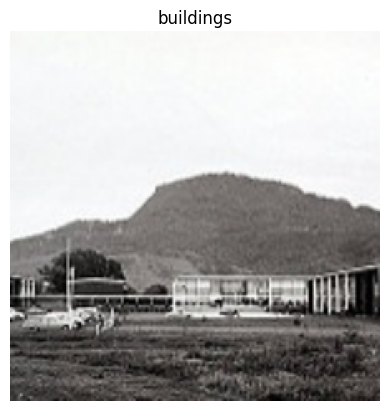

In [13]:
import matplotlib.pyplot as plt

img, label = train_ds[0]
plt.imshow(img.permute(1, 2, 0))
plt.title(train_ds.classes[label])
plt.axis("off")


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

num_classes = len(train_ds.classes)

class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = BaselineCNN(num_classes)
model


BaselineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(2):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 200 == 0:
            print(f"Epoch [{epoch+1}/2], Step [{i+1}/{len(train_loader)}], "
                  f"Loss: {running_loss/200:.4f}")
            running_loss = 0.0

print("Finished Training")
